In [17]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


# keras_ocrÏóêÏÑú Ï†úÍ≥µÌïòÎäî Detection Î∂àÎü¨ÏôÄ Ïù¥ÎØ∏ÏßÄ ÎÇ¥ Text Detection ÌïòÍ∏∞

In [18]:
from keras_ocr.detection import Detector
import os

HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [19]:
# craft_mlt_25k.h5 ÏùÄ keras_ocrÏóêÏÑú Ï†úÍ≥µÌïòÎäî ÌõàÎ†®Îêú ÎîîÌÖçÏÖòÏù¥Îã§.

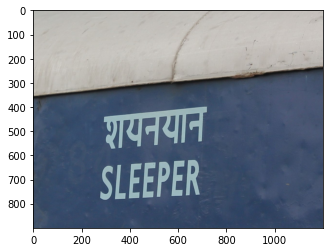

In [20]:
import matplotlib.pyplot as plt

img = cv2.imread(SAMPLE_IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Ïù¥ÎØ∏ÏßÄ ÌôïÏù∏
plt.imshow(img)
plt.show()

In [21]:
from PIL import Image, ImageDraw

def detect_text(img_path):
    # TODO
    # Ïù¥ÎØ∏ÏßÄ Î°úÎìú
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCVÎäî BGRÏù¥ÎØÄÎ°ú RGBÎ°ú Î≥ÄÌôò
    img_pil = PIL.Image.fromarray(img)  # PIL Ïù¥ÎØ∏ÏßÄ Î≥ÄÌôò
    
    # Î∞∞Ïπò ÌÅ¨Í∏∞Î•º ÏúÑÌï¥ÏÑú dimensionÏùÑ ÌôïÏû•Ìï¥Ï£ºÍ≥† kera-ocrÏùò ÏûÖÎ†• Ï∞®ÏõêÏóê ÎßûÍ≤å H,W,CÎ°ú Î≥ÄÍ≤ΩÌï©ÎãàÎã§.
    img_array = np.expand_dims(img, axis=0)  # Î∞∞Ïπò Ï∞®Ïõê Ï∂îÍ∞Ä (1, H, W, C)
    
    # Î∞∞ÏπòÏùò Ï≤´ Î≤àÏß∏ Í≤∞Í≥ºÎßå Í∞ÄÏ†∏ÏòµÎãàÎã§.
    ocr_result = detector.detect(img_array)[0]  # Ï≤´ Î≤àÏß∏ Î∞∞Ïπò Í≤∞Í≥º ÏÇ¨Ïö©
    
    # 4. Í≤∞Í≥º Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ± (ÏõêÎ≥∏ Î≥¥Ìò∏Î•º ÏúÑÌï¥ Î≥µÏÇ¨)
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)  # üîπ Ïó¨Í∏∞ÏÑú img_draw ÏÉùÏÑ±
    
    # ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ÏÑú xÏôÄ yÏ¢åÌëúÎ•º Î≥ÄÍ≤ΩÌï¥Ï§çÎãàÎã§. (ÏïûÏÑ† h dimensionÏúºÎ°ú Ïù∏Ìï¥ y,xÎ°ú ÌëúÍ∏∞Îê®)
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

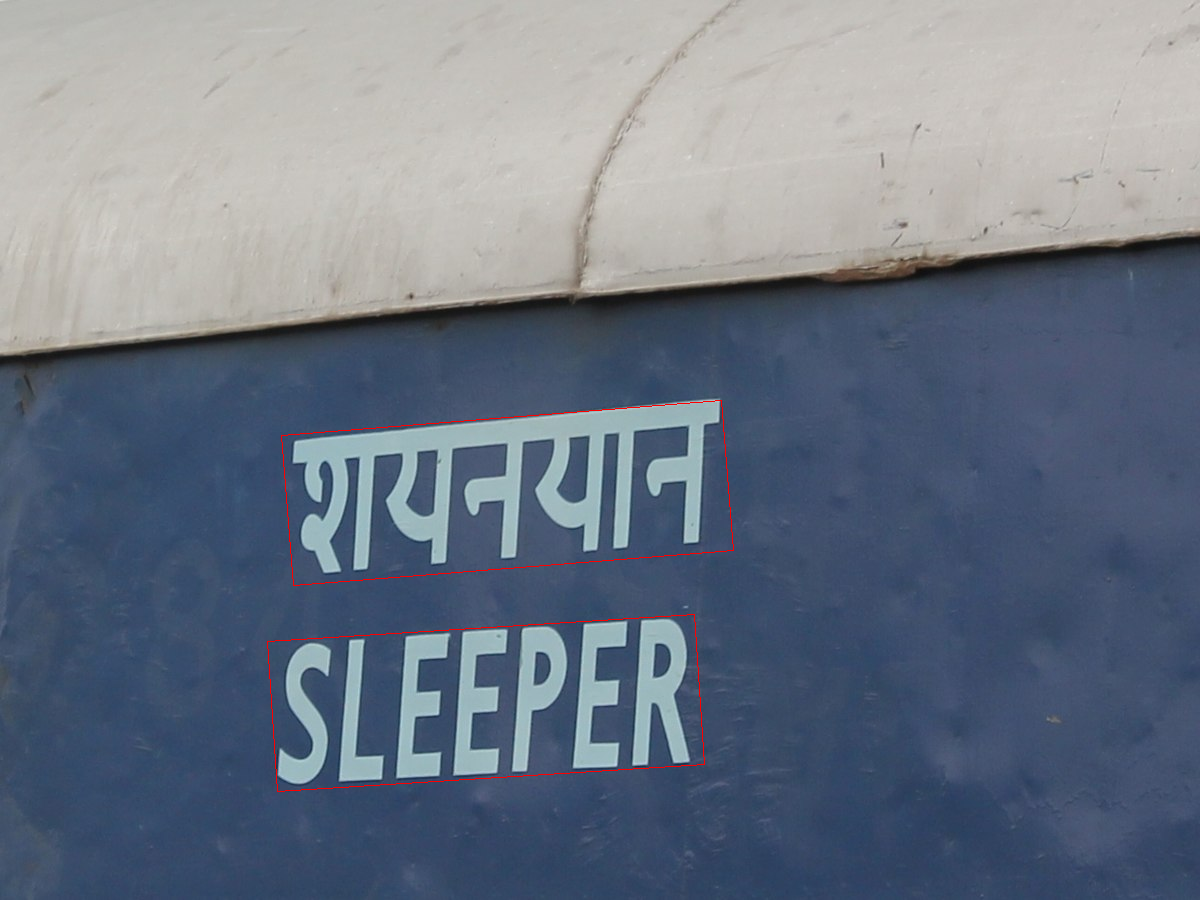

In [22]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [23]:
# Í∏∞Í∞Ä Îß§ÌÇ§ÎÑ§.

In [24]:
cropped_img

[<PIL.Image.Image image mode=RGB size=461x196 at 0x7D3E54C48A30>,
 <PIL.Image.Image image mode=RGB size=446x186 at 0x7D3E54C48A60>]

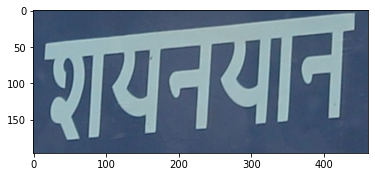

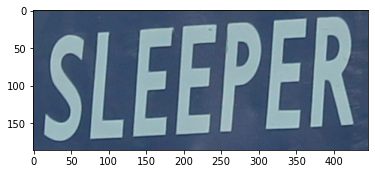

In [25]:
plt.imshow(cropped_img[0])
plt.show()

plt.imshow(cropped_img[1])
plt.show()

# Recognition modelÎ°ú Ïù∏ÏãùÌïòÍ∏∞

In [26]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


In [47]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


In [48]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


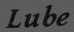

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


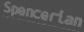

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


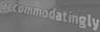

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


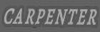

In [49]:
from IPython.display import display

# envÏóê Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨Ïò¨Í≤åÏöî
# lmdbÏóêÏÑú Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨Ïò¨ Îïå envÎùºÎäî Î≥ÄÏàòÎ™ÖÏùÑ ÏÇ¨Ïö©ÌïòÎäîÍ≤å ÏùºÎ∞òÏ†ÅÏù¥ÏóêÏöî
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# Î∂àÎü¨Ïò® Îç∞Ïù¥ÌÑ∞Î•º txn(transaction)Ïù¥ÎùºÎäî Î≥ÄÏàòÎ•º ÌÜµÌï¥ ÏóΩÎãàÎã§
# Ïù¥Ï†ú txnÎ≥ÄÏàòÎ•º ÌÜµÌï¥ ÏßÅÏ†ë Îç∞Ïù¥ÌÑ∞Ïóê Ï†ëÍ∑º Ìï† Ïàò ÏûàÏñ¥Ïöî
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # indexÎ•º Ïù¥Ïö©Ìï¥ÏÑú ÎùºÎ≤® ÌÇ§ÏôÄ Ïù¥ÎØ∏ÏßÄ ÌÇ§Î•º ÎßåÎì§Î©¥
        # txnÏóêÏÑú ÎùºÎ≤®Í≥º Ïù¥ÎØ∏ÏßÄÎ•º ÏùΩÏñ¥Ïò¨ Ïàò ÏûàÏñ¥Ïöî
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # Ïù¥ÎØ∏ÏßÄÎäî Î≤ÑÌçºÎ•º ÌÜµÌï¥ ÏùΩÏñ¥Ïò§Í∏∞ ÎïåÎ¨∏Ïóê 
        # Î≤ÑÌçºÏóêÏÑú Ïù¥ÎØ∏ÏßÄÎ°ú Î≥ÄÌôòÌïòÎäî Í≥ºÏ†ïÏù¥ Îã§Ïãú ÌïÑÏöîÌï¥Ïöî
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Î•º Ï∂úÎ†•Ìï¥ Î¥ÖÎãàÎã§
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # Ïù¥ÎØ∏ÏßÄ ÎπÑÏú®ÏùÑ Ïú†ÏßÄÌïòÎ©¥ÏÑú ÎÜíÏù¥Î•º 32Î°ú Î∞îÍøÄÍ±∞ÏóêÏöî
        # ÌïòÏßÄÎßå ÎÑàÎπÑÎ•º 100Î≥¥Îã§Îäî ÏûëÍ≤åÌïòÍ≥† Ïã∂Ïñ¥Ïöî
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # Ïù¥Ï†ú ÎÜíÏù¥Í∞Ä 32Î°ú ÏùºÏ†ïÌïú Ïù¥ÎØ∏ÏßÄÏôÄ ÎùºÎ≤®ÏùÑ Ìï®Íªò Ï∂úÎ†•Ìï† Ïàò ÏûàÏñ¥Ïöî       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [50]:
class MJDatasetSequence(Sequence):
    # Í∞ùÏ≤¥Î•º Ï¥àÍ∏∞Ìôî Ìï† Îïå lmdbÎ•º Ïó¥Ïñ¥ envÏóê Ï§ÄÎπÑÌï¥Îë°ÎãàÎã§
    # Îòê, lmdbÏóê ÏûàÎäî Îç∞Ïù¥ÌÑ∞ ÏàòÎ•º ÎØ∏Î¶¨ ÌååÏïÖÌï¥Îë°ÎãàÎã§
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # indexÏóê Ìï¥ÎãπÌïòÎäî imageÏôÄ labelÏùÑ ÏùΩÏñ¥ÏòµÎãàÎã§
    # ÏúÑÏóêÏÑú ÏÇ¨Ïö©Ìïú ÏΩîÎìúÏôÄ Îß§Ïö∞ Ïú†ÏÇ¨Ìï©ÎãàÎã§
    # labelÏùÑ Ï°∞Í∏à Îçî Îã§Îì¨Îäî Í≤ÉÏù¥ ÏïΩÍ∞Ñ Îã§Î¶ÖÎãàÎã§
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # labelÏùÑ ÏïΩÍ∞Ñ Îçî Îã§Îì¨ÏäµÎãàÎã§
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__ÏùÄ ÏïΩÏÜçÎêòÏñ¥ÏûàÎäî Î©îÏÑúÎìúÏûÖÎãàÎã§
    # Ïù¥ Î∂ÄÎ∂ÑÏùÑ ÏûëÏÑ±ÌïòÎ©¥ sliceÌï† Ïàò ÏûàÏäµÎãàÎã§
    # ÏûêÏÑ∏Ìûà ÏïåÍ≥† Ïã∂Îã§Î©¥ ÏïÑÎûò Î¨∏ÏÑúÎ•º Ï∞∏Í≥†ÌïòÏÑ∏Ïöî
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idxÏóê Ìï¥ÎãπÌïòÎäî index_listÎßåÌÅº Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨
    # 2. imageÏôÄ labelÏùÑ Î∂àÎü¨Ïò§Í≥† 
    # 3. ÏÇ¨Ïö©ÌïòÍ∏∞ Ï¢ãÏùÄ inputsÍ≥º outputsÌòïÌÉúÎ°ú Î∞òÌôòÌï©ÎãàÎã§
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # Ïù∏ÏΩîÎî© Í≥ºÏ†ïÏóêÏÑú '-'Ïù¥ Ï∂îÍ∞ÄÎêòÎ©¥ max_text_lenÎ≥¥Îã§ Í∏∏Ïñ¥Ïßà Ïàò ÏûàÏñ¥Ïöî
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [51]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # Í∞ôÏùÄ Î¨∏Ïûê ÏÇ¨Ïù¥Ïóê Í≥µÎ∞± Î¨∏Ïûê labelÏùÑ ÏÇΩÏûÖ
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [52]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [53]:
def ctc_lambda_func(args): # CTC lossÎ•º Í≥ÑÏÇ∞ÌïòÍ∏∞ ÏúÑÌïú Lambda Ìï®Ïàò
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [54]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [67]:
# Îç∞Ïù¥ÌÑ∞ÏÖãÍ≥º Î™®Îç∏ÏùÑ Ï§ÄÎπÑÌï©ÎãàÎã§
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# Î™®Îç∏ÏùÑ Ïª¥ÌååÏùº Ìï©ÎãàÎã§
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [68]:
# ÌõàÎ†®Ïù¥ Îπ®Î¶¨ ÎÅùÎÇ† Ïàò ÏûàÎèÑÎ°ù ModelCheckPointÏôÄ EarlyStoppingÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§
# ModelCheckPointÏùò Í≤ΩÏö∞ 'val_loss'Î•º Î™®ÎãàÌÑ∞ÎßÅÌïòÍ≥† weightÎßå Ï†ÄÏû•ÌïòÎäî ÏòµÏÖòÏúºÎ°ú ÏßÄÏ†ïÌï¥Ï£ºÏÑ∏Ïöî.
# EarlyStoppingÎèÑ 'val_loss'Î•º Î™®ÎãàÌÑ∞ÎßÅÌï¥Ï£ºÏÑ∏Ïöî.
# (EarlyStoppingÏùÑ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÎäî Í≤ΩÏö∞, model.fit()Ïùò epoch ÏòµÏÖòÏùÑ 20 Ï†ïÎèÑÎ°ú ÏÑ§Ï†ïÌï¥Ï£ºÏÑ∏Ïöî.

checkpoint_path = './model_checkpoint.hdf5'

# Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏΩúÎ∞± ÏÑ§Ï†ï (Í∞ÄÏû• Ï¢ãÏùÄ Î™®Îç∏ÏùÑ Ï†ÄÏû•)
ckp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,  # Ï†ÄÏû•Ìï† Î™®Îç∏ Í≤ΩÎ°ú
    monitor='val_loss',        # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïùò ÏÜêÏã§Í∞íÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Ï†ÄÏû•
    save_best_only=True,       # Í∞ÄÏû• Ï¢ãÏùÄ Î™®Îç∏Îßå Ï†ÄÏû•
    save_weights_only=True,   # Ï†ÑÏ≤¥ Î™®Îç∏ Ï†ÄÏû• (TrueÏù¥Î©¥ Í∞ÄÏ§ëÏπòÎßå Ï†ÄÏû•)
    mode='min',                # ÏµúÏÜåÍ∞íÏù¥ Í∞ÄÏû• Ï¢ãÏùÄ Í∞í
    verbose=1                  # Ï†ÄÏû•Îê† Îïå Î©îÏãúÏßÄ Ï∂úÎ†•
)

# ÏñºÎ¶¨Ïä§ÌÉëÌïë ÏΩúÎ∞± ÏÑ§Ï†ï (Í≥ºÏ†ÅÌï© Î∞©ÏßÄ)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏÜêÏã§Í∞í Í∏∞Ï§Ä
    patience=10,          # ÏÑ±Îä• Ìñ•ÏÉÅÏù¥ ÏóÜÏùÑ Îïå 5Ìöå Í∏∞Îã§Î¶∞ ÌõÑ ÌïôÏäµ Ï§ëÎã®
    restore_best_weights=True,  # Í∞ÄÏû• Ï¢ãÏùÄ Í∞ÄÏ§ëÏπò Î≥µÏõê
    mode='min',                 # ÏµúÏÜåÍ∞íÏù¥ Í∞ÄÏû• Ï¢ãÏùÄ Í∞í
    verbose=1
)

model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=50,
          validation_data=val_set,
          validation_steps=len(val_set),
          # ModelCheckPointÏôÄ EarlyStoppingÏùÑ ÌôúÏö©ÌïòÎäî Í≤ΩÏö∞ Î∞îÎ°ú ÏïÑÎûò callbacks ÏòµÏÖòÏóê Ï£ºÏÑùÏùÑ ÌíÄÏñ¥Ï£ºÏÑ∏Ïöî.
          callbacks=[ckp, earlystop]
)

Epoch 1/50
565/565 [==============================] - 93s 152ms/step - loss: 25.5834 - val_loss: 23.5522

Epoch 00001: val_loss improved from inf to 23.55223, saving model to ./model_checkpoint.hdf5
Epoch 2/50
565/565 [==============================] - 84s 149ms/step - loss: 15.9679 - val_loss: 10.0555

Epoch 00002: val_loss improved from 23.55223 to 10.05555, saving model to ./model_checkpoint.hdf5
Epoch 3/50
565/565 [==============================] - 84s 149ms/step - loss: 7.4751 - val_loss: 6.6140

Epoch 00003: val_loss improved from 10.05555 to 6.61401, saving model to ./model_checkpoint.hdf5
Epoch 4/50
565/565 [==============================] - 85s 151ms/step - loss: 5.2975 - val_loss: 5.6487

Epoch 00004: val_loss improved from 6.61401 to 5.64871, saving model to ./model_checkpoint.hdf5
Epoch 5/50
565/565 [==============================] - 84s 149ms/step - loss: 4.1621 - val_loss: 4.9308

Epoch 00005: val_loss improved from 5.64871 to 4.93083, saving model to ./model_checkpoint.h

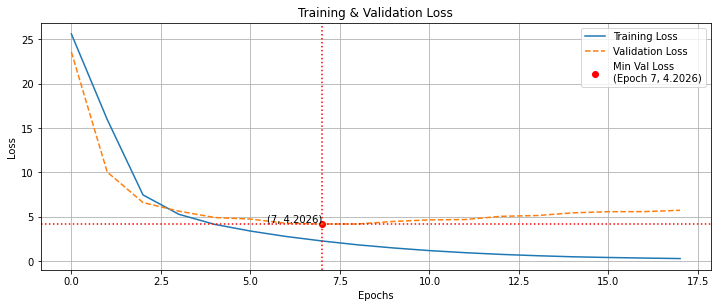

In [70]:
# ‚úÖ Î™®Îç∏ ÌõàÎ†® ÌõÑ history Í∞ùÏ≤¥ ÌôïÏù∏ ÌïÑÏöî
history = model.history  # Î™®Îç∏ ÌõàÎ†® ÌõÑ Îã§Ïãú Ìï†Îãπ ÌïÑÏöî

# ‚úÖ ÏÜêÏã§ Î∞è Ï†ïÌôïÎèÑ Í∞í Í∞ÄÏ†∏Ïò§Í∏∞
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# ‚úÖ Validation Í∏∞Ï§Ä ÏµúÌïòÏ†ê (Loss) & ÏµúÍ≥†Ï†ê (Accuracy) Ï∞æÍ∏∞
min_val_loss_epoch = np.argmin(val_loss)  # ÏµúÏÜå validation lossÏùò epoch
min_val_loss = val_loss[min_val_loss_epoch]

# max_val_acc_epoch = np.argmax(val_acc)  # ÏµúÎåÄ validation accuracyÏùò epoch
# max_val_acc = val_acc[max_val_acc_epoch]

# ‚úÖ ÏÜêÏã§ (Loss) Í∑∏ÎûòÌîÑ
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='dashed')

# ÏµúÏÜå validation loss ÏßÄÏ†ê ÌëúÏãú
plt.scatter(min_val_loss_epoch, min_val_loss, color='red', label=f'Min Val Loss\n(Epoch {min_val_loss_epoch}, {min_val_loss:.4f})')
plt.text(min_val_loss_epoch, min_val_loss, f'({min_val_loss_epoch}, {min_val_loss:.4f})', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# Ï†êÏÑ† Ï∂îÍ∞Ä (Í∞ÄÎ°ú, ÏÑ∏Î°ú)
plt.axvline(min_val_loss_epoch, linestyle='dotted', color='red')
plt.axhline(min_val_loss, linestyle='dotted', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

# # ‚úÖ Ï†ïÌôïÎèÑ (Accuracy) Í∑∏ÎûòÌîÑ
# plt.subplot(2, 1, 2)
# plt.plot(train_acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy', linestyle='dashed')

# # ÏµúÎåÄ validation accuracy ÏßÄÏ†ê ÌëúÏãú
# plt.scatter(max_val_acc_epoch, max_val_acc, color='blue', label=f'Max Val Accuracy\n(Epoch {max_val_acc_epoch}, {max_val_acc:.4f})')
# plt.text(max_val_acc_epoch, max_val_acc, f'({max_val_acc_epoch}, {max_val_acc:.4f})', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# # Ï†êÏÑ† Ï∂îÍ∞Ä (Í∞ÄÎ°ú, ÏÑ∏Î°ú)
# plt.axvline(max_val_acc_epoch, linestyle='dotted', color='blue')
# plt.axhline(max_val_acc, linestyle='dotted', color='blue')

# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training & Validation Accuracy')
# plt.legend()
# plt.grid()

# ‚úÖ Í∑∏ÎûòÌîÑ Ï∂úÎ†•
plt.show()

In [71]:
# 7ÏóêÌè¨ÌÅ¨ Ïù¥ÌõÑ Ïò§Î≤ÑÌîºÌåÖÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÎã§.
# Î©îÌä∏Î¶≠Ïù¥ ÏóÜÏñ¥ÏÑú ÏïÑÏâΩÎã§. Ï∂îÌõÑ Ïó¨Ïú†Í∞Ä ÎêòÎ©¥ "Character Error Rate (CER)"Î•º Î©îÌä∏Î¶≠ÏúºÎ°ú ÌôúÏö©Ìï¥ Î≥¥ÏïÑÏïº Í≤†Îã§.

### ÏïÑÎûò CellÏùÄ ÎØ∏Î¶¨ ÌïôÏäµÎêú Í∞ÄÏ§ëÏπòÎ•º Î∂àÎü¨Ïò§Îäî Í≤É.

In [220]:
# Îã§ÏùåÏùÄ ÌïôÏäµÎêú Î™®Îç∏Ïùò Í∞ÄÏ§ëÏπòÍ∞Ä Ï†ÄÏû•Îêú Í≤ΩÎ°úÏûÖÎãàÎã§
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# Îç∞Ïù¥ÌÑ∞ÏÖãÍ≥º Î™®Îç∏ÏùÑ Î∂àÎü¨ÏòµÎãàÎã§
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn Î™®Îç∏ÏùÄ ÏûÖÎ†•Ïù¥ Î≥µÏû°Ìïú Íµ¨Ï°∞Ïù¥ÎØÄÎ°ú Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©Ìï† ÏàòÍ∞Ä ÏóÜÏäµÎãàÎã§
# Í∑∏ÎûòÏÑú crnn Î™®Îç∏Ïùò ÏûÖÎ†•Ï§ë 'input_image' Î∂ÄÎ∂ÑÎßå ÏÇ¨Ïö©Ìïú Î™®Îç∏ÏùÑ ÏÉàÎ°ú ÎßåÎì§Í≤ÅÎãàÎã§
# inference Ï†ÑÏö© Î™®Îç∏Ïù¥ÏóêÏöî 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [73]:
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


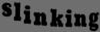

Result: 	 ALEPPO99999999999999999


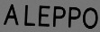

Result: 	 FWENDA999999999999999999


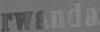

Result: 	 NATHANS99999999999999999


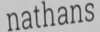

Result: 	 HALLB999999999999999999


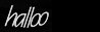

Result: 	 HURIS9999999999999999999


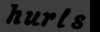

Result: 	 DOWNSIZE9999999999999999


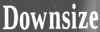

Result: 	 ROBOTIC99999999999999999


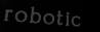

Result: 	 SLOPPY99999999999999999


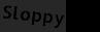

Result: 	 HERMITE99999999999999999


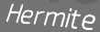

In [74]:
from IPython.display import display

# Î™®Îç∏Ïù¥ inferenceÌïú Í≤∞Í≥ºÎ•º Í∏ÄÏûêÎ°ú Î∞îÍøîÏ£ºÎäî Ïó≠Ìï†ÏùÑ Ìï©ÎãàÎã§
# ÏΩîÎìú ÌïòÎÇòÌïòÎÇòÎ•º Ïù¥Ìï¥ÌïòÍ∏∞Îäî Ï°∞Í∏à Ïñ¥Î†§Ïö∏ Ïàò ÏûàÏäµÎãàÎã§
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# Î™®Îç∏Í≥º Îç∞Ïù¥ÌÑ∞ÏÖãÏù¥ Ï£ºÏñ¥ÏßÄÎ©¥ inferenceÎ•º ÏàòÌñâÌï©ÎãàÎã§
# indexÍ∞ú ÎßåÌÅºÏùò Îç∞Ïù¥ÌÑ∞Î•º ÏùΩÏñ¥ Î™®Îç∏Î°ú inferenceÎ•º ÏàòÌñâÌïòÍ≥†
# Í≤∞Í≥ºÎ•º ÎîîÏΩîÎî©Ìï¥ Ï∂úÎ†•Ìï¥Ï§çÎãàÎã§
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

In [75]:
# Ï†ïÏÑ±Ï†ÅÏù∏ ÌèâÍ∞ÄÎ•º Ìï¥Î≥¥ÏûêÎ©¥ Îç∞Ïù¥ÌÑ∞ 10Í∞ú Ï§ë 2Í∞úÏóê Ïò§Î•òÍ∞Ä ÏûàÍ≥†, Ï¥ù 4Í∞ú Î¨∏ÏûêÎ•º ÏûòÎ™ª Ïù∏ÏãùÌñàÎã§.
# Îí∑Î∂ÄÎ∂ÑÏóê 9Í∞Ä Ïó∞ÏÜçÏúºÎ°ú ÎÇòÏò§Îäî Í≤ÉÏùÄ ÏïÑÎßàÎèÑ Ìå®Îî©Í∞íÏù∏ÎìØ ÌïòÎã§. Ïù¥Î•º ÎÇòÏò§ÏßÄ ÏïäÍ≤åÌï† Î∞©Î≤ïÏùÑ Ï∞æÏïÑÎ≥¥ÏïÑÏïº ÌïúÎã§.
# Ï†ïÎüâÏ†ÅÏù∏ ÌèâÍ∞ÄÎ•º ÏúÑÌïú Î©îÌä∏Î¶≠Ïù¥ ÌïÑÏöîÌïòÎã§.

# End-to-End Ìï®Ïàò Íµ¨ÌòÑ

In [76]:
# ÏúÑÏóêÏÑú ÏàòÌñâÌïú DetectionÍ≥º RecognitionÏùÑ Îã®ÏàúÌûà Ïó∞Í≤∞ÌïòÏó¨ End to End Ìï®ÏàòÎ•º ÎßåÎì§Ïñ¥ Î≥¥Ïûê.

In [112]:
from PIL import Image, ImageDraw

def detect_text(img):
    # Ïù¥ÎØ∏ÏßÄ Î°úÎìú
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCVÎäî BGRÏù¥ÎØÄÎ°ú RGBÎ°ú Î≥ÄÌôò
    img_pil = PIL.Image.fromarray(img)  # PIL Ïù¥ÎØ∏ÏßÄ Î≥ÄÌôò
    
    # Î∞∞Ïπò ÌÅ¨Í∏∞Î•º ÏúÑÌï¥ÏÑú dimensionÏùÑ ÌôïÏû•Ìï¥Ï£ºÍ≥† kera-ocrÏùò ÏûÖÎ†• Ï∞®ÏõêÏóê ÎßûÍ≤å H,W,CÎ°ú Î≥ÄÍ≤ΩÌï©ÎãàÎã§.
    img_array = np.expand_dims(img, axis=0)  # Î∞∞Ïπò Ï∞®Ïõê Ï∂îÍ∞Ä (1, H, W, C)
    
    # Î∞∞ÏπòÏùò Ï≤´ Î≤àÏß∏ Í≤∞Í≥ºÎßå Í∞ÄÏ†∏ÏòµÎãàÎã§.
    ocr_result = detector.detect(img_array)[0]  # Ï≤´ Î≤àÏß∏ Î∞∞Ïπò Í≤∞Í≥º ÏÇ¨Ïö©
    
    # 4. Í≤∞Í≥º Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ± (ÏõêÎ≥∏ Î≥¥Ìò∏Î•º ÏúÑÌï¥ Î≥µÏÇ¨)
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)  # üîπ Ïó¨Í∏∞ÏÑú img_draw ÏÉùÏÑ±
    
    # ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ÏÑú xÏôÄ yÏ¢åÌëúÎ•º Î≥ÄÍ≤ΩÌï¥Ï§çÎãàÎã§. (ÏïûÏÑ† h dimensionÏúºÎ°ú Ïù∏Ìï¥ y,xÎ°ú ÌëúÍ∏∞Îê®)
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

original image width:446, height:186
target_img_size:(76, 32)
display img shape:(76, 32, 3)


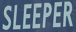

In [82]:
img = cropped_img[1]
width, height = img.size
print('original image width:{}, height:{}'.format(width, height))

# Ïù¥ÎØ∏ÏßÄ ÎπÑÏú®ÏùÑ Ïú†ÏßÄÌïòÎ©¥ÏÑú ÎÜíÏù¥Î•º 32Î°ú Î∞îÍøÄÍ±∞ÏóêÏöî
# ÌïòÏßÄÎßå ÎÑàÎπÑÎ•º 100Î≥¥Îã§Îäî ÏûëÍ≤åÌïòÍ≥† Ïã∂Ïñ¥Ïöî
target_width = min(int(width*32/height), 100)
target_img_size = (target_width,32)        
print('target_img_size:{}'.format(target_img_size))        
img = np.array(img.resize(target_img_size)).transpose(1,0,2)

# Ïù¥Ï†ú ÎÜíÏù¥Í∞Ä 32Î°ú ÏùºÏ†ïÌïú Ïù¥ÎØ∏ÏßÄÏôÄ ÎùºÎ≤®ÏùÑ Ìï®Íªò Ï∂úÎ†•Ìï† Ïàò ÏûàÏñ¥Ïöî       
print('display img shape:{}'.format(img.shape))
display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

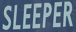

In [129]:
def img_preprocessing(img):
    width, height = img.size
    
    # Ïù¥ÎØ∏ÏßÄ ÎπÑÏú®ÏùÑ Ïú†ÏßÄÌïòÎ©¥ÏÑú ÎÜíÏù¥Î•º 32Î°ú Î∞îÍøÄÍ±∞ÏóêÏöî
    # ÌïòÏßÄÎßå ÎÑàÎπÑÎ•º 100Î≥¥Îã§Îäî ÏûëÍ≤åÌïòÍ≥† Ïã∂Ïñ¥Ïöî
    target_width = min(int(width*32/height), 100)
    target_img_size = (target_width,32)        
      
    img = np.array(img.resize(target_img_size)).transpose(1,0,2)
    
    return img

# Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú ÏÑ§Ï†ï Î∞è Î∂àÎü¨Ïò§Í∏∞
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

img = cropped_img[1]
    
img = img_preprocessing(img)
display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

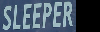

In [151]:
def img_preprocessing(img, target_width=100, target_height=32):
    img = np.array(img)
    """
    Ïù¥ÎØ∏ÏßÄ ÎπÑÏú®ÏùÑ Ïú†ÏßÄÌïòÎ©¥ÏÑú Ïò§Î•∏Ï™ΩÏóê Zero-paddingÏùÑ Ï∂îÍ∞ÄÌïòÎäî Ìï®Ïàò
    - img: ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ (numpy array)
    - target_width: Î™®Îç∏ ÏûÖÎ†• ÌÅ¨Í∏∞ (Í∏∞Î≥∏Í∞í 100)
    - target_height: Î™®Îç∏ ÏûÖÎ†• ÎÜíÏù¥ (Í∏∞Î≥∏Í∞í 32)
    """
    # ÌòÑÏû¨ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞
    current_height, current_width = img.shape[:2]  # (height, width, channels)

    # ÎπÑÏú® Ïú†ÏßÄÌïòÎ©¥ÏÑú ÎÜíÏù¥Î•º 32Î°ú Ï°∞Ï†ï
    resize_width = int(current_width * (target_height / current_height))
    resize_width = min(resize_width, target_width)  # 100Î≥¥Îã§ ÌÅ¨ÏßÄ ÏïäÎèÑÎ°ù Ï†úÌïú

    # Î¶¨ÏÇ¨Ïù¥Ïßï (cv2Îäî (width, height) ÏàúÏÑú ÌïÑÏöî)
    img_resized = cv2.resize(img, (resize_width, target_height), interpolation=cv2.INTER_LINEAR)

    # Ìå®Îî© Ï∂îÍ∞Ä (Ïò§Î•∏Ï™Ω)
    padding_width = target_width - resize_width
    img_padded = cv2.copyMakeBorder(img_resized, 0, 0, 0, padding_width, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    return img_padded

img = cropped_img[1]
    
padded_img = img_preprocessing(img)

display(Image.fromarray(padded_img))

In [86]:
model_pred.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 32, 3)]      0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 100, 32, 64)       1792      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 50, 16, 64)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 50, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 25, 8, 128)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 25, 8, 256)        295168    
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 25, 8, 256)        590

In [ ]:
# Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÍ∞Ä (76, 32, 3) Ïù¥ÏßÄÎßå, Î™®Îç∏Ïùò ÏûÖÎ†•ÏùÄ (None, 100, 32, 3)Ïù¥Îã§.
# Îî∞ÎùºÏÑú widthÎ•º 100ÏúºÎ°ú Ìå®Îî©Ìï¥Ï£ºÏñ¥Ïïº ÌïúÎã§. Ï†úÎ°úÌå®Îî©Ïù¥ Ï†ÅÏ†àÌï† Í≤É Í∞ôÎã§.

In [152]:
padded_img.shape

(32, 100, 3)

In [153]:
padded_img = padded_img.reshape((1, *padded_img.shape))  # (1, 32, 100, 3)
print(f"Padded Image with Batch Dimension: {padded_img.shape}")

Padded Image with Batch Dimension: (1, 32, 100, 3)


In [154]:
# Î∞∞Ïπò Ï∞®ÏõêÏùÑ Ï∂îÍ∞ÄÌïú ÌõÑ (1, 32, 100, 3) ‚Üí (1, 100, 32, 3)Î°ú Î≥ÄÌôò
padded_img = np.transpose(padded_img, (0, 2, 1, 3))

print(f"Transposed Image Shape: {padded_img.shape}")  # (1, 100, 32, 3)

Transposed Image Shape: (1, 100, 32, 3)


In [106]:
output = model_pred.predict(padded_img)
result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
result

'SLEEPER9999999999999999'

In [165]:
def ocr_end_to_end(img, model_pred):
    img_pil, cropped_imgs = detect_text(img)
    result_ls = list()
    
    for cropped_img in cropped_imgs:
        img = np.array(cropped_img)
        
        # Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ (Ï¢ÖÌö°ÎπÑ Ïú†ÏßÄÌïòÎ©¥ÏÑú ÎÜíÏù¥ 32, ÎÑàÎπÑ ÏµúÎåÄ 100ÏúºÎ°ú resize)
        padded_img = img_preprocessing(img)
        padded_img = padded_img.reshape((1, *padded_img.shape))  # (1, 32, 100, 3)
        padded_img = np.transpose(padded_img, (0, 2, 1, 3)) # (1, 100, 32, 3)
        
        output = model_pred.predict(padded_img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        result_ls.append(result)
        
    return cropped_imgs, result_ls     

In [166]:
# Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú ÏÑ§Ï†ï Î∞è Î∂àÎü¨Ïò§Í∏∞
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

img = cv2.imread(SAMPLE_IMG_PATH)

# Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌõàÎ†®Îêú Í∞ÄÏ§ëÏπò Î∂àÎü¨Ïò§Í∏∞

checkpoint_path = './model_checkpoint.hdf5'
model = build_crnn_model()
model.load_weights(checkpoint_path)

# inference Ï†ÑÏö© Î™®Îç∏Ïù¥ÏóêÏöî 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

# TARGET_CHARACTERS ÏÉùÏÑ±(Ïà´Ïûê+ÏòÅÎ¨∏ ÎåÄÎ¨∏Ïûê)
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS 

Recognition Í≤∞Í≥º : WRFRIF99999999999999999


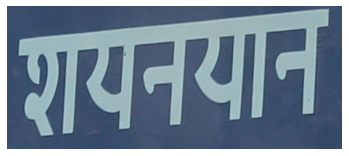

Recognition Í≤∞Í≥º : SLEEPER9999999999999999


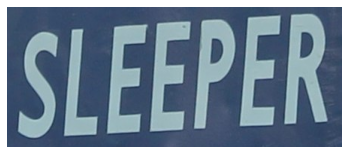

In [171]:
cropped_imgs, result_ls = ocr_end_to_end(img, model_pred)

for cropped_img, result in zip(cropped_imgs, result_ls):
    print(f'Recognition Í≤∞Í≥º : {result}')
    plt.imshow(cropped_img)
    plt.axis('off')
    plt.show()

In [161]:
# ÏùºÎã® end-to-endÎ°ú Ïñ¥ÎñªÍ≤åÎì† ÎèôÏûëÏùÄ ÌïòÎãàÍπê.. ÌïúÏûîÌï¥~

# Îí§Ïóê 9Í∞Ä Ïó∞ÏÜçÏ†ÅÏúºÎ°ú ÎÇòÏò§Îäî ÏõêÏù∏ÏùÑ ÌååÏïÖÌïòÍ≥†, Ïù¥Î•º Ìï¥Í≤∞ÌïòÏûê.

decoded_text=[19, 12, 9, 14, 11, 9, 14, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Result: 	 SLINKING9999999999999999


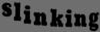

In [184]:
from IPython.display import display

# Î™®Îç∏Ïù¥ inferenceÌïú Í≤∞Í≥ºÎ•º Í∏ÄÏûêÎ°ú Î∞îÍøîÏ£ºÎäî Ïó≠Ìï†ÏùÑ Ìï©ÎãàÎã§
# ÏΩîÎìú ÌïòÎÇòÌïòÎÇòÎ•º Ïù¥Ìï¥ÌïòÍ∏∞Îäî Ï°∞Í∏à Ïñ¥Î†§Ïö∏ Ïàò ÏûàÏäµÎãàÎã§
def decode_predict_ctc_test(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    decoded_text = list()
    for index in indexes:
        text += chars[index]
        decoded_text.append(index)
    print(f'{decoded_text=}')
    results.append(text)
    return results

# Î™®Îç∏Í≥º Îç∞Ïù¥ÌÑ∞ÏÖãÏù¥ Ï£ºÏñ¥ÏßÄÎ©¥ inferenceÎ•º ÏàòÌñâÌï©ÎãàÎã§
# indexÍ∞ú ÎßåÌÅºÏùò Îç∞Ïù¥ÌÑ∞Î•º ÏùΩÏñ¥ Î™®Îç∏Î°ú inferenceÎ•º ÏàòÌñâÌïòÍ≥†
# Í≤∞Í≥ºÎ•º ÎîîÏΩîÎî©Ìï¥ Ï∂úÎ†•Ìï¥Ï§çÎãàÎã§
def check_inference_test(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc_test(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference_test(model_pred, test_set, index=1)

In [185]:
# -1Í∞íÏù¥ Ìå®Îî©ÏúºÎ°ú Ï†ÅÏö©ÎêòÏñ¥ Î∞òÌôòÎêòÎäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÎã§.
# -1Í∞íÏùÑ ÏóÜÏï†Ï£ºÎ©¥ ÏûêÏó∞Ïä§ÎüΩÍ≤å Ìå®Îî©Î∂ÄÎ∂ÑÏùÄ ÏÇ≠Ï†úÎê† Í≤É Í∞ôÎã§.

Result: 	 SLINKING


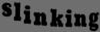

In [193]:
from IPython.display import display

# Î™®Îç∏Ïù¥ inferenceÌïú Í≤∞Í≥ºÎ•º Í∏ÄÏûêÎ°ú Î∞îÍøîÏ£ºÎäî Ïó≠Ìï†ÏùÑ Ìï©ÎãàÎã§
# ÏΩîÎìú ÌïòÎÇòÌïòÎÇòÎ•º Ïù¥Ìï¥ÌïòÍ∏∞Îäî Ï°∞Í∏à Ïñ¥Î†§Ïö∏ Ïàò ÏûàÏäµÎãàÎã§
def decode_predict_ctc_test(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
#     print(f'{indexes=}')

    # ÏïûÎí§Î°ú -1Ïù¥ Ïó∞ÏÜçÏúºÎ°ú ÏûàÏùÑ Í≤ΩÏö∞ ÏÇ≠Ï†ú
    indexes = list(indexes)
    while indexes and indexes[0] == -1:
        indexes.pop(0)
    while indexes and indexes[-1] == -1:
        indexes.pop()
        
    text = ""
#     decoded_text = list()
    
    for index in indexes:
        text += chars[index]
#         decoded_text.append(index)
#     print(f'{decoded_text=}')
    results.append(text)
    return results

# Î™®Îç∏Í≥º Îç∞Ïù¥ÌÑ∞ÏÖãÏù¥ Ï£ºÏñ¥ÏßÄÎ©¥ inferenceÎ•º ÏàòÌñâÌï©ÎãàÎã§
# indexÍ∞ú ÎßåÌÅºÏùò Îç∞Ïù¥ÌÑ∞Î•º ÏùΩÏñ¥ Î™®Îç∏Î°ú inferenceÎ•º ÏàòÌñâÌïòÍ≥†
# Í≤∞Í≥ºÎ•º ÎîîÏΩîÎî©Ìï¥ Ï∂úÎ†•Ìï¥Ï§çÎãàÎã§
def check_inference_test(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc_test(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference_test(model_pred, test_set, index=1)

In [188]:
# Ìï¥Í≤∞ ÏôÑÎ£å

Result: 	 SLINKING


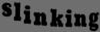

Result: 	 ALEPPO


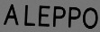

Result: 	 FWENDA


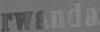

Result: 	 NATHANS


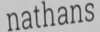

Result: 	 HALLB


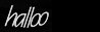

Result: 	 HURIS


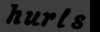

Result: 	 DOWNSIZE


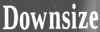

Result: 	 ROBOTIC


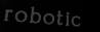

Result: 	 SLOPPY


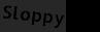

Result: 	 HERMITE


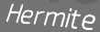

In [194]:
check_inference_test(model_pred, test_set, index=10)

Recognition Í≤∞Í≥º : VEGURN


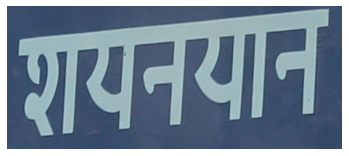

Recognition Í≤∞Í≥º : SLEEPER


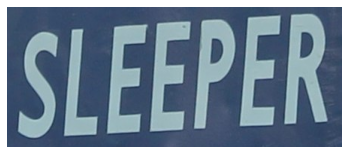

In [232]:
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
#     print(f'{indexes=}')

    # ÏïûÎí§Î°ú -1Ïù¥ Ïó∞ÏÜçÏúºÎ°ú ÏûàÏùÑ Í≤ΩÏö∞ ÏÇ≠Ï†ú
    indexes = list(indexes)
    while indexes and indexes[0] == -1:
        indexes.pop(0)
    while indexes and indexes[-1] == -1:
        indexes.pop()
        
    text = ""
#     decoded_text = list()
    
    for index in indexes:
        text += chars[index]
#         decoded_text.append(index)
#     print(f'{decoded_text=}')
    results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

def ocr_end_to_end(img, model_pred):
    img_pil, cropped_imgs = detect_text(img)
    result_ls = list()
    
    for cropped_img in cropped_imgs:
        img = np.array(cropped_img)
        
        # Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ (Ï¢ÖÌö°ÎπÑ Ïú†ÏßÄÌïòÎ©¥ÏÑú ÎÜíÏù¥ 32, ÎÑàÎπÑ ÏµúÎåÄ 100ÏúºÎ°ú resize)
        padded_img = img_preprocessing(img)
        padded_img = padded_img.reshape((1, *padded_img.shape))  # (1, 32, 100, 3)
        padded_img = np.transpose(padded_img, (0, 2, 1, 3)) # (1, 100, 32, 3)
        
        output = model_pred.predict(padded_img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        result_ls.append(result)
        
    return cropped_imgs, result_ls    

cropped_imgs, result_ls = ocr_end_to_end(img, model_pred)

for cropped_img, result in zip(cropped_imgs, result_ls):
    print(f'Recognition Í≤∞Í≥º : {result}')
    plt.imshow(cropped_img)
    plt.axis('off')
    plt.show()

# OCRÏùÑ Ï†ïÎüâÏ†ÅÏúºÎ°ú ÌèâÍ∞ÄÌï† Ïàò ÏûàÎäî MetricÏùÑ ÏïåÏïÑÎ≥¥Ïûê.

In [240]:
test_set[0][0].keys()

dict_keys(['input_image', 'label', 'input_length', 'label_length'])

In [241]:
test_set[0][0]['label'][0], len(test_set[0][0]['label'][0])

(array([19, 12,  9, 14, 11,  9, 14,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0]),
 22)

In [207]:
label_converter.decode(test_set[0][0]['label'][0])

'SLINKING--------------'

In [218]:
len(test_set[0])

2

In [226]:
inputs, outputs = test_set[0]
inputs["label"]

array([[19, 12,  9, ...,  0,  0,  0],
       [18,  5, 13, ...,  0,  0,  0],
       [ 3,  8, 18, ...,  0,  0,  0],
       ...,
       [13,  9,  4, ...,  0,  0,  0],
       [17,  1,  4, ...,  0,  0,  0],
       [16,  5,  1, ...,  0,  0,  0]])

In [243]:
test_set[0]["input_image"]

TypeError: tuple indices must be integers or slices, not str

In [245]:
import numpy as np

def compute_accuracy(model, test_set, label_converter):
    """
    Î™®Îç∏ ÏòàÏ∏° Í≤∞Í≥ºÏôÄ Ïã§Ï†ú Ï†ïÎãµÏùÑ ÎπÑÍµêÌïòÏó¨ Ï†ïÌôïÎèÑÎ•º Í≥ÑÏÇ∞
    """
    total_samples = 0
    correct_samples = 0
    total_chars = 0
    correct_chars = 0
    
    for batch in test_set:
        inputs, _ = batch  # üî• (inputs, outputs) ÌäúÌîåÏóêÏÑú inputsÎßå ÏÇ¨Ïö©
        images = inputs["input_image"]
        gt_encoded = inputs["label"]  # Ìå®Îî©Îêú Ï†ïÏàò ÎùºÎ≤®
        label_lengths = inputs["label_length"]  # Ïã§Ï†ú Ï†ïÎãµ Í∏∏Ïù¥

        batch_size = len(images)

        # Î™®Îç∏ ÏòàÏ∏° ÏàòÌñâ (ÏòàÏ∏°Îêú Î¨∏ÏûêÏó¥ Î∞òÌôò)
        preds = model.predict(images)

        # Ï†ïÎãµ ÎùºÎ≤®ÏùÑ ÎîîÏΩîÎî© (Ìå®Îî© Ï†úÍ±∞ ÌõÑ Î¨∏ÏûêÏó¥ Î≥ÄÌôò)
        gt_texts = [label_converter.decode(gt[:label_lengths[i]]) for i, gt in enumerate(gt_encoded)]

        for i in range(batch_size):
            pred_text = preds[i]  # Î™®Îç∏Ïùò ÏòàÏ∏° Í≤∞Í≥º
            gt_text = gt_texts[i]  # Ïã§Ï†ú Ï†ïÎãµ
            
            # Î¨∏Ïûê Îã®ÏúÑ ÎπÑÍµê
            correct_chars += sum(p == g for p, g in zip(pred_text, gt_text))
            total_chars += max(len(pred_text), len(gt_text))  # Ïã§Ï†ú Îã®Ïñ¥ Í∏∏Ïù¥ Í∏∞Ï§Ä

            # Î¨∏Ïû• Ï†ÑÏ≤¥ ÎπÑÍµê
            if pred_text == gt_text:
                correct_samples += 1

            total_samples += 1

    # Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
    exact_match_accuracy = correct_samples / total_samples
    char_accuracy = correct_chars / total_chars

    print(f"Exact Match Accuracy: {exact_match_accuracy:.2%}")
    print(f"Character Accuracy: {char_accuracy:.2%}")

    return exact_match_accuracy, char_accuracy

# Î™®Îç∏ Ï†ïÌôïÎèÑ ÌèâÍ∞Ä Ïã§Ìñâ
compute_accuracy(model_pred, test_set, label_converter)


/tmp/ipykernel_31/1618707063.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  correct_chars += sum(p == g for p, g in zip(pred_text, gt_text))
/tmp/ipykernel_31/1618707063.py:35: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pred_text == gt_text:


Exact Match Accuracy: 0.00%
Character Accuracy: 0.00%


(0.0, 0.0)

In [ ]:
# ÏãúÍ∞ÑÍ¥ÄÍ≥ÑÏÉÅ Î©îÌä∏Î¶≠ÏùÄ Ï†úÎåÄÎ°ú ÌôïÏù∏Ìï¥Î≥¥ÏßÄ Î™ªÌñàÎÑ§Ïöî..
# ÏúµÎãò ÏûòÎ™ªÌñàÏñ¥Ïöî..„Ö† ÎïåÎ¶¨ÏßÄÎßå ÎßêÏïÑÏ£ºÏÑ∏Ïöî..